In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

from src.ForecastModel.utils.metrics import calculate_nse, calculate_kge, calculate_bias, load_metrics
from src.ForecastModel.utils.postprocessing import ModelHandler

import numpy as np
import pandas as pd

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

In [2]:
PLOT_PATH = r"plots"
DATA_PATH = r"src\data\Dataset.csv"

In [3]:
models = {
    "arima": ModelHandler("ARIMA",
                r"rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "black",
                ls = "--",
                  ),
     "elstm": ModelHandler("eLSTM",
                   r"rst\eLSTM",
                   is_final_model = True,
                   color = '#984ea3',
                   ls = "-",
                 ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
               r"rst\PBHM-HLSTM",
               is_final_model = True,
               color = "#e41a1c",
               ls = "-",
              )
     }

In [4]:
# calculate metrics of hydrologic model per fold
dfh = pd.read_csv(DATA_PATH, parse_dates=['time'])

hyd_metrics = {}
for year in range(2012, 2018):
      dfp = dfh.loc[dfh["time"].dt.year == year]
      hyd_metrics[year] = {
          "kge":  calculate_kge(dfp.qmeasval.values, dfp.qsim.values),
          "nse":  calculate_nse(dfp.qmeasval.values, dfp.qsim.values),
          "bias": calculate_bias(dfp.qmeasval.values, dfp.qsim.values),
      }    
    

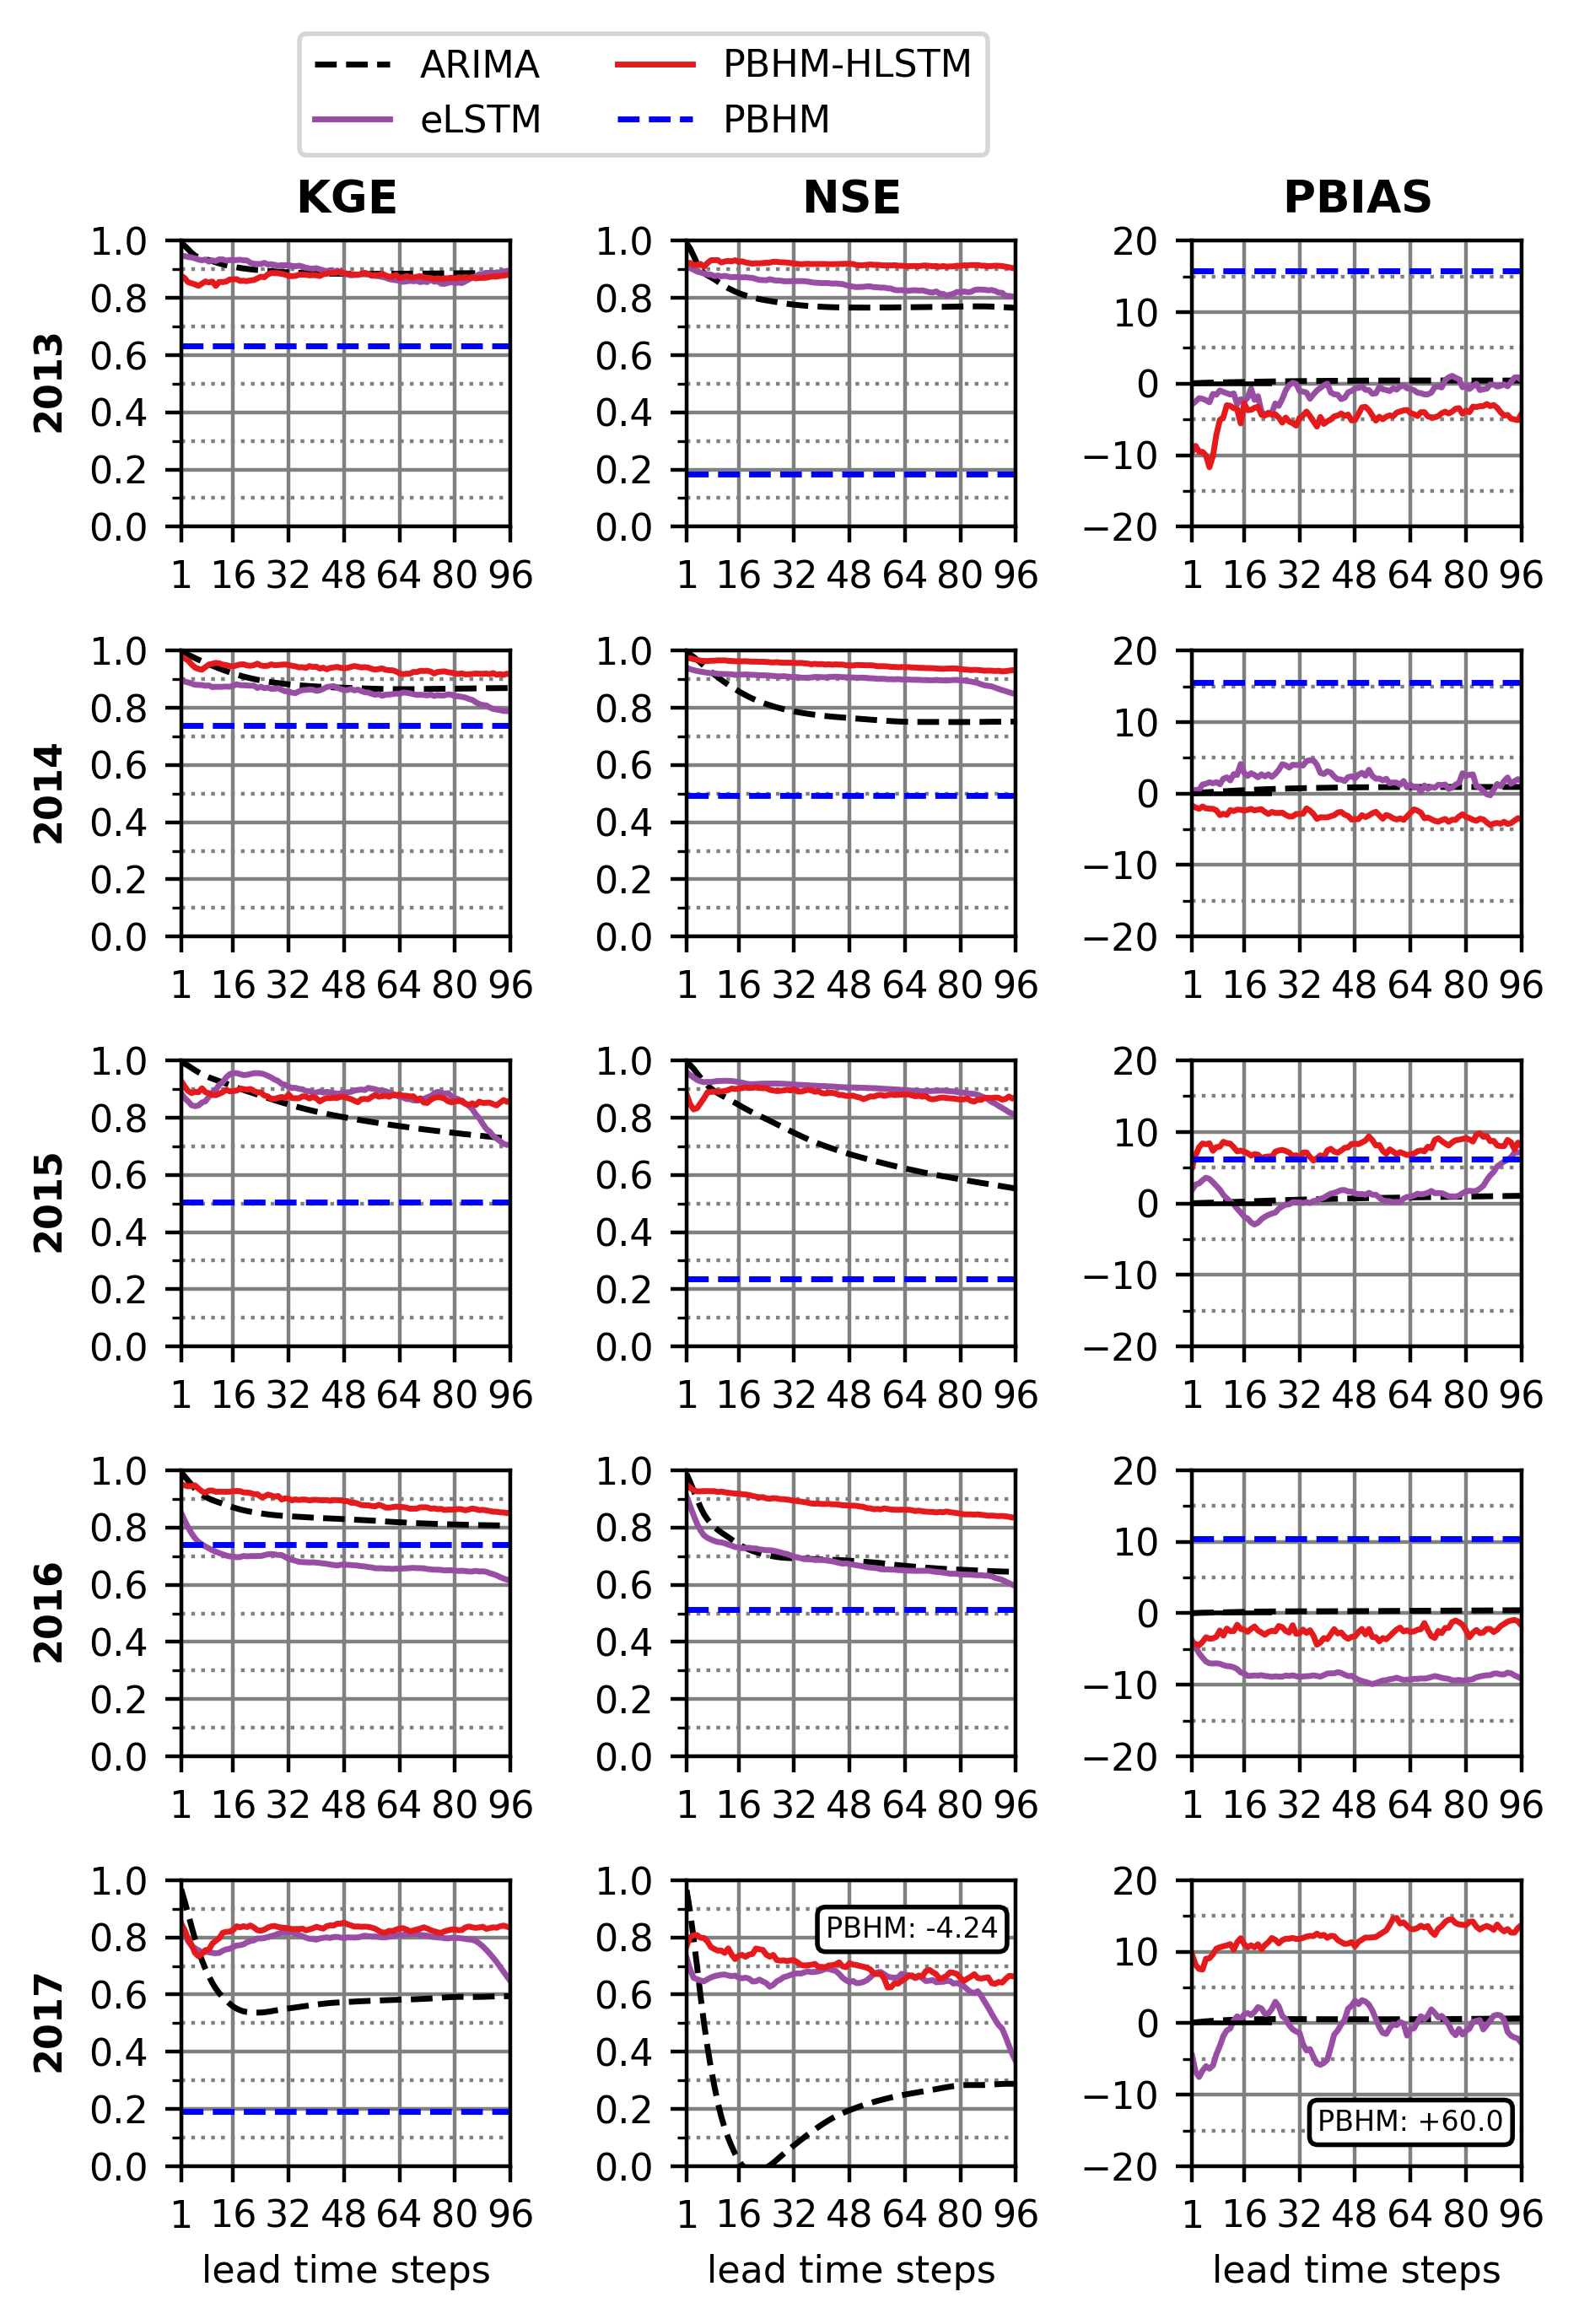

In [5]:
fig, axes = plt.subplots(5,3,figsize=(4.72,6.5), dpi=400)

metric_names = ["kge", "nse", "bias"]
metric_labels = ["KGE", "NSE", "PBIAS"]
ylims = [(0,1), (-2,1)]


xx = np.arange(1,97)
df = pd.DataFrame(columns=["name", "year", 
                           "kge_pass", "nse_pass",
                           "kge_min", "kge_avg", "kge_max", 
                           "nse_min", "nse_avg", "nse_max", 
                          ])

n_row = -5
for n, key in enumerate(models.keys()):
    metrics = load_metrics(os.path.join(models[key].lg_path, "metrics_eval.txt"))
    
    n_row += 5
    for j, met in enumerate(metric_names):
        metric  = metrics["test"][met]
        for i in range(5):
            df.loc[n_row+i, ["name", "year"]] = [models[key].name, 2013+i]
            df.loc[n_row+i, [f"{met}_min", f"{met}_avg", f"{met}_max"]] = [np.min(metric[i]), 
                                                                           np.mean(metric[i]), 
                                                                           np.max(metric[i])]
            df.loc[n_row+i, [f"{met}_{x}" for x in range(96)]] = [metric[i][x] for x in range(96)]
            xx = np.arange(1,np.array(metric[i]).shape[0]+1)
            axes[i,j].plot(xx, metric[i], color=models[key].color, ls=models[key].ls, label=f"{models[key].name}", lw=1.25)


for i in range(5):
    for j, met in enumerate(metric_names):
        if i == 0:
            axes[i,j].set_title(r"$\bf{"+f"{metric_labels[j]}"+r"}$")
        elif i == 4:
            axes[i,j].set_xlabel("lead time steps")
        if j == 0:
            axes[i,j].set_ylabel(r"$\bf{"+f"{2013 + i}"+r"}$")

        axes[i,j].hlines(hyd_metrics[2013+i][metric_names[j]], 1, 96, color="b", ls = "--", label="PBHM", lw=1.25)
        if (i == 4) & (j == 1):
            metric_hyd = hyd_metrics[2013+i][metric_names[j]]
            axes[i,j].text(91,0.8, f"PBHM: {metric_hyd:+4.2f}", color="k", ha="right", fontsize=6,
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                     })
        if (i == 4) & (j == 2):
            metric_hyd = hyd_metrics[2013+i][metric_names[j]]
            axes[i,j].text(91,-15, f"PBHM: {metric_hyd:+4.1f}", color="k", ha="right", fontsize=6,
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                     })
            
            
        axes[i,j].set_xticks([1,16,32,48,64,80,96])
        if j == 2:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(10))
            axes[i,j].yaxis.set_minor_locator(MultipleLocator(5))
            axes[i,j].set_ylim((-20,20))
            axes[i,j].hlines(0, 0, 24, color="k", lw=1)
        else:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(0.2))
            axes[i,j].yaxis.set_minor_locator(MultipleLocator(0.1))
            axes[i,j].set_ylim((0,1))

        axes[i,j].set_xlim((1,96))
        
        axes[i,j].grid(which='major', color='grey', linestyle='-')
        axes[i,j].grid(which='minor', color='grey', linestyle=':')

fig.tight_layout()
axes[0,1].legend(bbox_to_anchor=(-0.13, 1.3), 
                 loc='lower center', ncol=2, 
                 borderaxespad=0)


In [6]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, 'fig5_leadtime_performance-alt.png'), bbox_inches="tight", dpi=300)

In [7]:
df.loc[5:, :].filter(regex='^nse')

,nse_pass,nse_min,nse_avg,nse_max,nse_0,nse_1,nse_2,nse_3,nse_4,nse_5,...,nse_86,nse_87,nse_88,nse_89,nse_90,nse_91,nse_92,nse_93,nse_94,nse_95
5,NaN,0.802678,0.845648,0.911951,0.911951,0.904746,0.898302,0.892328,0.888924,0.885369,...,0.828486,0.826370,0.827671,0.824043,0.818604,0.817770,0.807269,0.806765,0.804905,0.802678
6,NaN,0.84717,0.902426,0.939621,0.939621,0.934982,0.931471,0.928569,0.926378,0.924498,...,0.878325,0.876443,0.874673,0.870217,0.865963,0.861873,0.858397,0.854104,0.850601,0.847170
7,NaN,0.810921,0.901531,0.959337,0.959337,0.949080,0.940394,0.931911,0.926814,0.924327,...,0.870207,0.863042,0.854639,0.849245,0.840980,0.834206,0.827063,0.818626,0.813798,0.810921
8,NaN,0.594231,0.684377,0.908311,0.908311,0.875476,0.843094,0.813257,0.789743,0.772590,...,0.631837,0.631789,0.629283,0.623808,0.620775,0.617252,0.611313,0.605450,0.600108,0.594231
9,NaN,0.365707,0.638627,0.727888,0.727888,0.688306,0.658572,0.653682,0.649392,0.646374,...,0.574510,0.554962,0.533210,0.512320,0.493479,0.481309,0.452919,0.420960,0.390645,0.365707
10,NaN,0.902632,0.917097,0.93204,0.921821,0.922353,0.914778,0.915069,0.918797,0.909064,...,0.912546,0.910822,0.911488,0.912539,0.912365,0.911214,0.909214,0.906984,0.904530,0.902632
11,NaN,0.927423,0.948828,0.975328,0.975328,0.972985,0.969968,0.967302,0.964777,0.963815,...,0.929415,0.930017,0.929803,0.928623,0.929501,0.927423,0.928056,0.929811,0.931488,0.930978
12,NaN,0.828856,0.879598,0.906373,0.880995,0.847234,0.828856,0.833044,0.850239,0.868148,...,0.868935,0.869314,0.868443,0.870346,0.869528,0.862886,0.865341,0.873923,0.866415,0.872534
13,NaN,0.834203,0.879677,0.949695,0.949695,0.939389,0.930544,0.926403,0.926535,0.927405,...,0.843090,0.841194,0.841743,0.840722,0.839836,0.840346,0.839255,0.837473,0.834968,0.834203
14,NaN,0.624776,0.699873,0.808017,0.770167,0.800367,0.807231,0.808017,0.798689,0.797952,...,0.658668,0.660318,0.640045,0.637690,0.643973,0.641674,0.654309,0.665448,0.664435,0.661228
